In [1]:
%%capture setup_output
%run 'setup.ipynb'

In [4]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from xgboost import XGBRegressor, plot_importance
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from src.data_processing import load_and_process_data
from src.plot_results import plot_regression_results, plot_average_error_by_bins, plot_prediction_distribution
from src.metrics.evaluate import evaluate_regression, compute_median_80_percent_error

In [3]:
# Define dataset file path
file_path = 'results/removed_outliers.parquet'
df = pd.read_parquet(file_path)

# Define features and target variables

# removed 'c_chargingmethod','c_chargingtype' 'mean_dep_time','latitude', 'longitude',  'start_datetime'
relevant_features = ['c_vin', 'c_realstartsoc', 'weekday_numerical', 'is_weekend',
                     'mean_consumption', 'mean_duration', 'latitude', 'longitude',
                     'start_hour', 'start_day', 'is_home_spot', 'is_location_one',
                     'start_datetime', 'delta_soc_real', 'plugin_duration_hr']
# 'delta_soc_real' or 'plugin_duration_hr'
target = 'delta_soc_real'

df = df[relevant_features]

In [5]:
print(len(df))
df = df.dropna()
print(len(df))

8637446
8631511


In [6]:
# Sort the DataFrame by 'c_vin' and 'start_datetime'
df = df.sort_values(by=['c_vin', 'start_datetime'])

# Add new features for previous session plugin_duration_hr and delta_soc_real
df['prev_plugin_duration_hr'] = df.groupby('c_vin')['plugin_duration_hr'].shift(1)
df['prev_delta_soc_real'] = df.groupby('c_vin')['delta_soc_real'].shift(1)

df['prev_plugin_duration_hr'] = df['prev_plugin_duration_hr'].fillna(df['plugin_duration_hr'])
df['prev_delta_soc_real'] = df['prev_delta_soc_real'].fillna(df['delta_soc_real'])

In [7]:
label_encoder = LabelEncoder()
df['c_vin_encoded'] = label_encoder.fit_transform(df['c_vin'])
df = df.drop(columns=['c_vin'])

features = ['c_vin_encoded', 'c_realstartsoc', 'weekday_numerical', 'is_weekend',
            'mean_consumption', 'mean_duration', 'latitude', 'longitude',
            'start_hour', 'start_day', 'is_home_spot', 'is_location_one',
            'prev_plugin_duration_hr', 'prev_delta_soc_real']


feature_scaler = StandardScaler()
target_scaler = StandardScaler()

df[features] = feature_scaler.fit_transform(df[features])
df[[target]] = target_scaler.fit_transform(df[[target]])

In [8]:
X = df[features]
y = df[[target]]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [10]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

7768359 863152
7768359 863152


In [11]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [28]:
# Runs on cpu, aws incompatibility issue. Should work on AWS 3.0.
xgbr = XGBRegressor(enable_categorical=True, device="cuda")

In [ ]:
xgb_params = {'nthread':[-1], #when use hyperthread, xgboost may become slower
              'learning_rate': [.03, 0.07, 0.05],
              'max_depth': [7, 10],
              'min_child_weight': [4, 6, 9],
              'subsample': [0.7],
              'colsample_bytree': [0.7, 1],
              'n_estimators': [500, 1000]}

gsXGB = GridSearchCV(xgbr, xgb_params, cv=7, scoring='neg_mean_squared_error',
                     refit=True, n_jobs=-1, verbose=True)
gsXGB.fit(X_train, y_train)

XGB_best = gsXGB.best_estimator_

# gsXGB.best_score_
best_params = gsXGB.best_params_
best_score = gsXGB.best_score_
joblib.dump(gsXGB.best_estimator_, 'xgboost_results/latest/best_xgb_soc.pkl')


with open('xgboost_results/latest/best_xgb_dur.txt', 'w') as f:
    f.write("Best parameters:\n")
    for param, value in best_params.items():
        f.write(f"{param}: {value}\n")
    f.write(f"\nBest score: {best_score}\n")


In [ ]:
loaded_model = XGBRegressor()
XGB_best = joblib.load('xgboost_results/best_xgb_soc.pkl')
XGB_best.get_booster().feature_names = X.columns.tolist()

In [14]:
y_pred = XGB_best.predict(X_test)

In [15]:
y_test_original = target_scaler.inverse_transform(y_test)
y_pred_original = target_scaler.inverse_transform(y_pred.reshape(-1, 1))

In [ ]:
metrics = evaluate_regression(y_test_original, y_pred_original)
print("Evaluation Metrics:", metrics)

In [15]:
median_80_error = compute_median_80_percent_error(y_test_original, y_pred_original)
print(f"Median 80% Average Error: {median_80_error}")

Median 80% Average Error: 2.0688126881917324


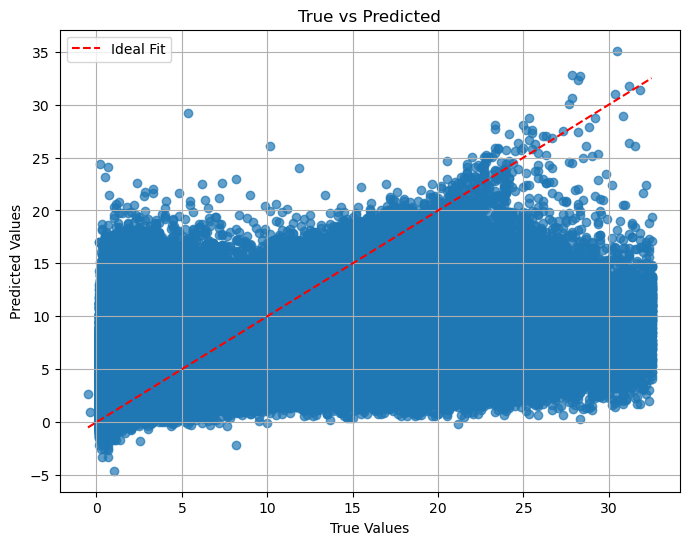

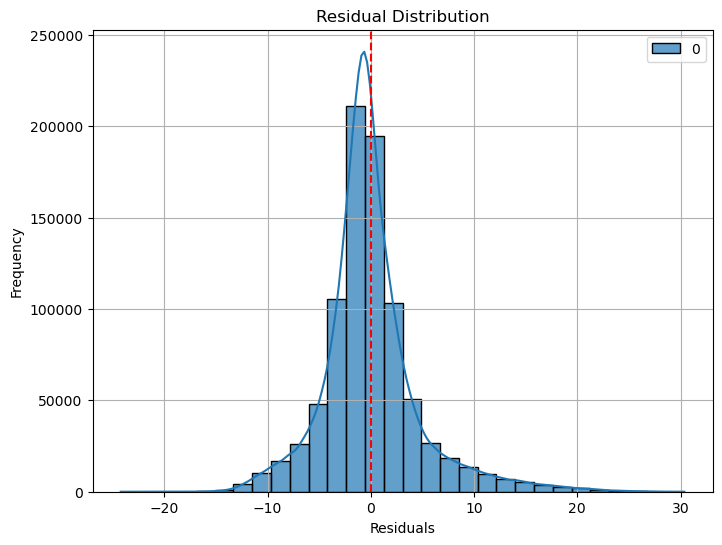

In [16]:
plot_regression_results(y_test_original, y_pred_original, savefig=False, name='xgb-dur')

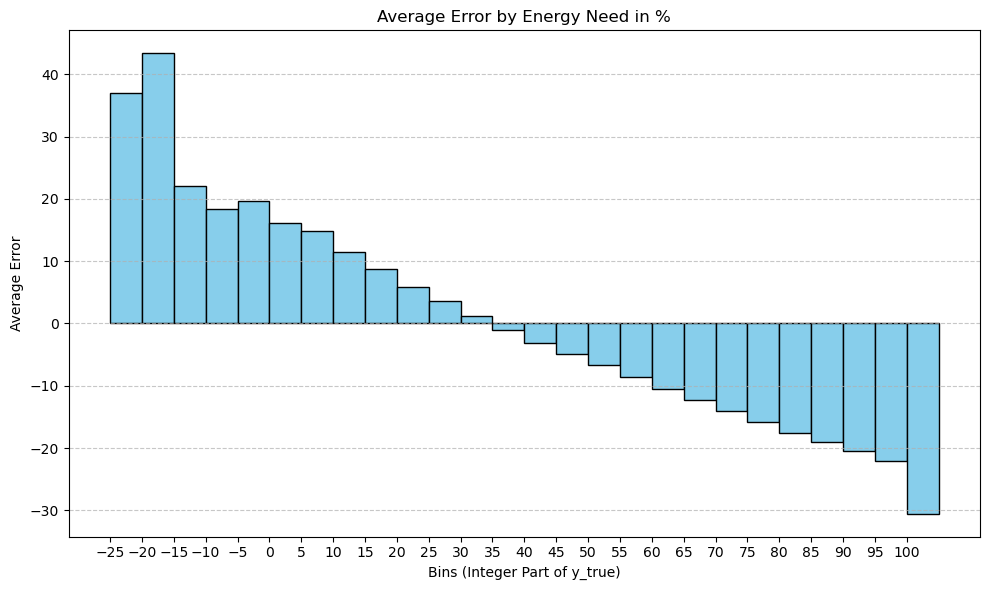

,bin,count,avg_error
0,-25,5.0,36.965881
1,-20,5.0,43.343666
2,-15,2.0,22.029839
3,-10,6.0,18.305613
4,-5,12.0,19.667379
5,0,22900.0,16.060274
6,5,66425.0,14.792969
7,10,69165.0,11.479831
8,15,68550.0,8.745915
9,20,70200.0,5.874124


In [19]:
plot_average_error_by_bins(y_test_original, y_pred_original, bin_size=5, savefig=False, name='xgb-soc')

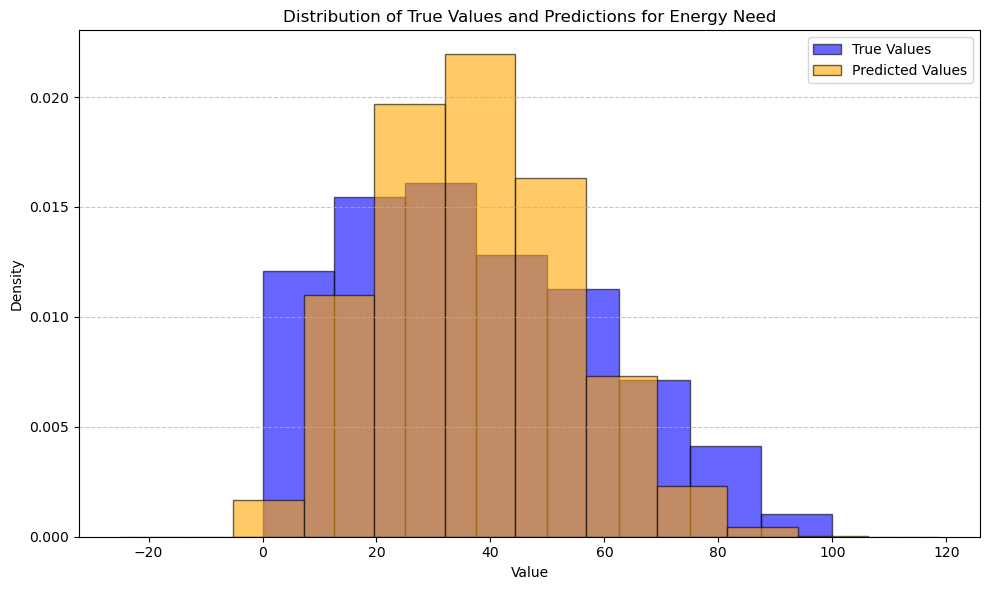

In [74]:
plot_prediction_distribution(y_test_original, y_pred_original, savefig=False, name='xgb-soc')

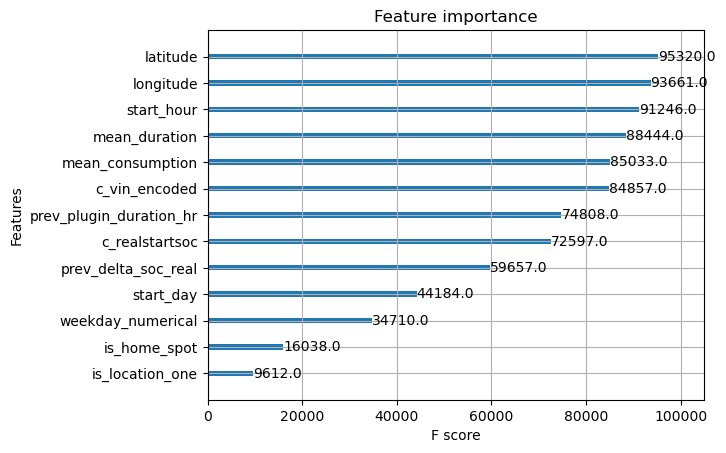

In [31]:
plot_importance(XGB_best)
plt.savefig("feature_importance_dur.png", dpi=300, bbox_inches="tight") # Save as PNG with high resolution